In [25]:
# create requirements.txt
# !pip3 install ipywidgets
!jupyter nbextension enable --py widgetsnbextension --sys-prefix

Enabling notebook extension jupyter-js-widgets/extension...
      - Validating: OK


In [18]:
import numpy as np
import matplotlib.pyplot as plt
import idx2numpy
import random
from urllib import request
import shutil
import gzip
import os
from tqdm import tqdm

In [2]:
DTYPE = np.float32

# Prepare the Dataset

### Download and unzip the MNIST dataset

In [3]:
base_url = 'http://yann.lecun.com/exdb/mnist/'

dataset = ['train-images.idx3-ubyte', 'train-labels.idx1-ubyte',
           't10k-images.idx3-ubyte', 't10k-labels.idx1-ubyte']

for file in dataset:
    
    _file = file.replace('.', '-') + '.gz'
    
    if _file not in os.listdir():
        with request.urlopen(f'{base_url}{_file}') as response, open(_file, 'wb') as out_file:
            shutil.copyfileobj(response, out_file)
    
    if file not in os.listdir():
        with gzip.open(_file, 'rb') as f_in, open(file, 'wb') as f_out:
            shutil.copyfileobj(f_in, f_out)

### Load the dataset

In [4]:
train_images = idx2numpy.convert_from_file(dataset[0]) / 255.0
train_labels = idx2numpy.convert_from_file(dataset[1])
test_images = idx2numpy.convert_from_file(dataset[2]) / 255.0
test_labels = idx2numpy.convert_from_file(dataset[3])

### Plot a random sample

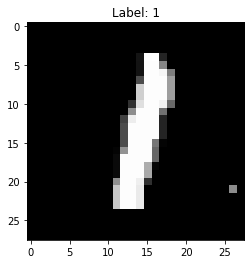

In [5]:
idx = random.randint(0, len(train_images))
plt.title(f'Label: {train_labels[idx]}')
plt.imshow(train_images[idx], cmap='gray')

In [6]:
def relu(vector):
    vector[vector<0] = 0
    return vector

In [7]:
def relu_derivative(vector):
    vector[vector<=0] = 0.0
    vector[vector>0] = 1.0
    return vector

In [8]:
def softmax(vector):
    exp = np.exp(vector)# - np.max(vector))
    return exp / exp.sum()

In [9]:
def cross_entropy(predict, label):
    return -np.sum(label*np.log(predict)).astype(DTYPE)

In [10]:
def cross_entropy_derivative(predict, label):
    return (-label/predict).astype(DTYPE)

In [11]:
def softmax_derivative(softmax):
    s = softmax.reshape(-1,1)
    return np.diagflat(s) - np.dot(s, s.T)

In [27]:
lr = 0.01

class CustomMnist:
    
    def __init__(self, input_shape=(28, 28)):
        
        input_shape = input_shape[0]*input_shape[1]
        self.layer1 = np.random.uniform(-1.0, 1.0, size=(input_shape, 128))/np.sqrt(input_shape*128)
        self.layer2 = np.random.uniform(-1.0, 1.0, size=(128, 10))/np.sqrt(128*10)
        
        self.layer1 = self.layer1.astype(DTYPE)
        self.layer2 = self.layer2.astype(DTYPE)
        
    def forward(self, image):
        
        self.flatten = np.reshape(image.astype(DTYPE), (1, image.shape[0]*image.shape[1]))
        self.inter1 = np.dot(self.flatten, self.layer1)
        self.acti1 = relu(self.inter1)
        self.inter2 = np.dot(self.acti1, self.layer2)        
        self.acti2 = softmax(self.inter2)
        
        return self.acti2
    
    def back_propagation(self, label):
        
        label_arr = np.zeros((1, 10))
        label_arr[0][label] = 1
        
        loss = cross_entropy(self.acti2, label_arr)
        d_cross_entropy = cross_entropy_derivative(self.acti2, label_arr)        
        d_softmax = np.dot(d_cross_entropy, softmax_derivative(self.acti2))
        d_layer2 = np.dot(self.acti1.T, d_softmax)
        d_acti1 = np.dot(d_softmax, self.layer2.T)
        d_relu = relu_derivative(self.acti1) * d_acti1
        d_layer1 = np.dot(self.flatten.T, d_relu)
        
        self.layer1 -= lr * d_layer1
        self.layer2 -= lr * d_layer2
        
    def loss(self):
        pass
        
    def view(self):
        
        print('\nLayers\n----------------------------')
        print('Layer1: \t', self.layer1.shape)
        print('Layer2: \t', self.layer2.shape, end='\n\n')
        print('Flatten: \t', self.flatten.shape)
        print('Inter1: \t', self.inter1.shape)
        print('Acti1:  \t', self.acti1.shape)
        print('Inter2: \t', self.inter2.shape)
        print('Acti2:  \t', self.acti2.shape)
        
                                        
custom_mnist = CustomMnist()


EPOCHS = 1
for epoch in range(EPOCHS):

    pbar = tqdm(zip(train_images[:1000], train_labels[:1000]), total=1000, ncols=80)
    pbar.set_description(f'Epoch: {epoch+1}/{EPOCHS}')
    
    for image, label in pbar:
        
        op = custom_mnist.forward(image)
        custom_mnist.back_propagation(label)

        label_arr = np.zeros((1, 10))
        label_arr[0][label] = 1

        loss = cross_entropy(op, label_arr)

        pbar.set_postfix(Loss=f'{loss:.4f}')
    
    
    
# custom_mnist.view()

Epoch: 1/1: 100%|█████████████| 1000/1000 [00:09<00:00, 107.19it/s, Loss=0.5629]


0
0


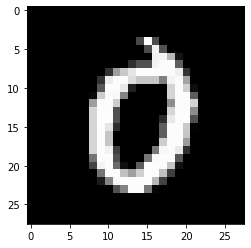

In [83]:
idx = random.randint(0, len(test_images))
a = custom_mnist.forward(test_images[idx])
print(np.argmax(a))
plt.imshow(test_images[idx], cmap='gray')
print(test_labels[idx])